# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

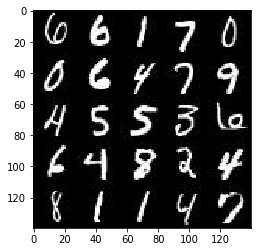

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

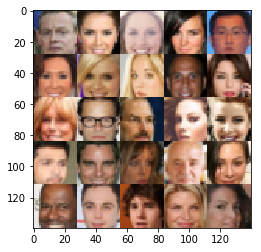

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    learning_rate = tf.placeholder(dtype = tf.float32)
    image_input = tf.placeholder(dtype = tf.float32, shape=(None, image_height, image_width, image_channels), name="image")
    z_input = tf.placeholder(dtype = tf.float32, shape=(None, z_dim), name="z_input")
    return image_input, z_input, learning_rate

tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training = True)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.reshape(x2, shape=(-1, 7*7*128))
        x3 = tf.layers.dense(x3, 7*7*128)
        
        logits = tf.layers.dense(x3, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        x0 = tf.layers.dense(z, 7*7*128)
        x0 = tf.reshape(x0, shape=(-1, 7, 7, 128))
        
        x1 = tf.layers.conv2d_transpose(x0, 64, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, out_channel_dim, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.maximum(alpha*x2, x2)

    return x2

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    alpha = 0.01
    g_model_output = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_fake_output, d_fake_logit = discriminator(g_model_output, alpha=alpha, reuse=False)
    d_real_output, d_real_logit = discriminator(input_real, alpha=alpha, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logit, labels=tf.ones_like(d_real_output)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.zeros_like(d_fake_output)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.ones_like(d_fake_output)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [62]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [63]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [64]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    show_every = 10
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers,
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % show_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),\
                          "Batch {}...".format(steps),\
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),\
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Batch 10... Discriminator Loss: 27.4841... Generator Loss: 0.0000
Epoch 1/10... Batch 20... Discriminator Loss: 0.0000... Generator Loss: 39.1579
Epoch 1/10... Batch 30... Discriminator Loss: 403.9384... Generator Loss: 0.0000
Epoch 1/10... Batch 40... Discriminator Loss: 4.4912... Generator Loss: 180.1840
Epoch 1/10... Batch 50... Discriminator Loss: 21.2428... Generator Loss: 96.5212
Epoch 1/10... Batch 60... Discriminator Loss: 9.8484... Generator Loss: 195.0719
Epoch 1/10... Batch 70... Discriminator Loss: 17.4353... Generator Loss: 39.0107
Epoch 1/10... Batch 80... Discriminator Loss: 0.0000... Generator Loss: 51.1749
Epoch 1/10... Batch 90... Discriminator Loss: 23.7451... Generator Loss: 0.0026
Epoch 1/10... Batch 100... Discriminator Loss: 0.0017... Generator Loss: 20.5487


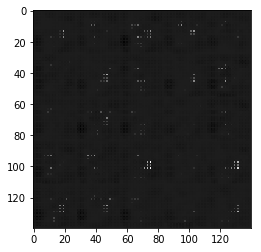

Epoch 1/10... Batch 110... Discriminator Loss: 0.0000... Generator Loss: 69.0694
Epoch 1/10... Batch 120... Discriminator Loss: 0.0000... Generator Loss: 102.9657
Epoch 1/10... Batch 130... Discriminator Loss: 0.0002... Generator Loss: 34.9800
Epoch 1/10... Batch 140... Discriminator Loss: 0.0000... Generator Loss: 162.1698
Epoch 1/10... Batch 150... Discriminator Loss: 0.0000... Generator Loss: 30.2527
Epoch 1/10... Batch 160... Discriminator Loss: 0.0014... Generator Loss: 85.5697
Epoch 1/10... Batch 170... Discriminator Loss: 0.0000... Generator Loss: 275.9692
Epoch 1/10... Batch 180... Discriminator Loss: 41.5635... Generator Loss: 0.0054
Epoch 1/10... Batch 190... Discriminator Loss: 131.9538... Generator Loss: 840.5764
Epoch 1/10... Batch 200... Discriminator Loss: 0.0000... Generator Loss: 395.0074


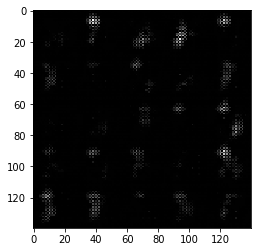

Epoch 1/10... Batch 210... Discriminator Loss: 6.7253... Generator Loss: 443.9227
Epoch 1/10... Batch 220... Discriminator Loss: 119.0817... Generator Loss: 52.0334
Epoch 1/10... Batch 230... Discriminator Loss: 0.0000... Generator Loss: 80.5733
Epoch 1/10... Batch 240... Discriminator Loss: 0.0000... Generator Loss: 53.7107
Epoch 1/10... Batch 250... Discriminator Loss: 0.0000... Generator Loss: 49.3649
Epoch 1/10... Batch 260... Discriminator Loss: 0.0000... Generator Loss: 137.0626
Epoch 1/10... Batch 270... Discriminator Loss: 0.0000... Generator Loss: 109.4603
Epoch 1/10... Batch 280... Discriminator Loss: 0.0000... Generator Loss: 105.6278
Epoch 1/10... Batch 290... Discriminator Loss: 0.0000... Generator Loss: 68.1761
Epoch 1/10... Batch 300... Discriminator Loss: 0.0000... Generator Loss: 61.9968


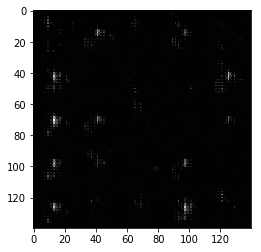

Epoch 1/10... Batch 310... Discriminator Loss: 0.0000... Generator Loss: 69.9700
Epoch 1/10... Batch 320... Discriminator Loss: 0.0131... Generator Loss: 17.4172
Epoch 1/10... Batch 330... Discriminator Loss: 0.0000... Generator Loss: 57.8579
Epoch 1/10... Batch 340... Discriminator Loss: 0.0000... Generator Loss: 40.3780
Epoch 1/10... Batch 350... Discriminator Loss: 0.0000... Generator Loss: 58.4876
Epoch 1/10... Batch 360... Discriminator Loss: 0.0000... Generator Loss: 42.8902
Epoch 1/10... Batch 370... Discriminator Loss: 0.0000... Generator Loss: 40.3501
Epoch 1/10... Batch 380... Discriminator Loss: 0.0000... Generator Loss: 20.0576
Epoch 1/10... Batch 390... Discriminator Loss: 0.0000... Generator Loss: 18.6276
Epoch 1/10... Batch 400... Discriminator Loss: 0.0000... Generator Loss: 54.9414


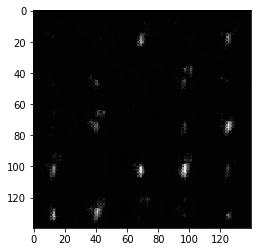

Epoch 1/10... Batch 410... Discriminator Loss: 0.0000... Generator Loss: 66.8200
Epoch 1/10... Batch 420... Discriminator Loss: 0.0000... Generator Loss: 45.0381
Epoch 1/10... Batch 430... Discriminator Loss: 0.0000... Generator Loss: 38.8389
Epoch 1/10... Batch 440... Discriminator Loss: 0.0000... Generator Loss: 37.6383
Epoch 1/10... Batch 450... Discriminator Loss: 0.0000... Generator Loss: 32.3130
Epoch 1/10... Batch 460... Discriminator Loss: 0.0000... Generator Loss: 28.2367
Epoch 1/10... Batch 470... Discriminator Loss: 0.0000... Generator Loss: 77.4082
Epoch 1/10... Batch 480... Discriminator Loss: 66.0367... Generator Loss: 176.6410
Epoch 1/10... Batch 490... Discriminator Loss: 6.0752... Generator Loss: 51.0797
Epoch 1/10... Batch 500... Discriminator Loss: 0.0000... Generator Loss: 178.0993


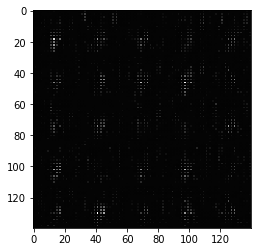

Epoch 1/10... Batch 510... Discriminator Loss: 0.0000... Generator Loss: 130.3901
Epoch 1/10... Batch 520... Discriminator Loss: 0.0000... Generator Loss: 85.9544
Epoch 1/10... Batch 530... Discriminator Loss: 0.0000... Generator Loss: 38.8910
Epoch 1/10... Batch 540... Discriminator Loss: 0.0000... Generator Loss: 69.3413
Epoch 1/10... Batch 550... Discriminator Loss: 0.0000... Generator Loss: 39.1703
Epoch 1/10... Batch 560... Discriminator Loss: 0.0001... Generator Loss: 41.1603
Epoch 1/10... Batch 570... Discriminator Loss: 0.0000... Generator Loss: 38.0557
Epoch 1/10... Batch 580... Discriminator Loss: 0.0000... Generator Loss: 45.3064
Epoch 1/10... Batch 590... Discriminator Loss: 0.0000... Generator Loss: 227.7151
Epoch 1/10... Batch 600... Discriminator Loss: 0.0006... Generator Loss: 145.3391


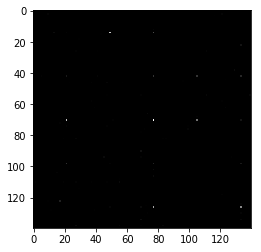

Epoch 1/10... Batch 610... Discriminator Loss: 0.0004... Generator Loss: 150.3880
Epoch 1/10... Batch 620... Discriminator Loss: 0.0000... Generator Loss: 94.1667
Epoch 1/10... Batch 630... Discriminator Loss: 0.0000... Generator Loss: 56.7181
Epoch 1/10... Batch 640... Discriminator Loss: 0.0000... Generator Loss: 37.4832
Epoch 1/10... Batch 650... Discriminator Loss: 0.0003... Generator Loss: 22.3964
Epoch 1/10... Batch 660... Discriminator Loss: 0.0000... Generator Loss: 27.9624
Epoch 1/10... Batch 670... Discriminator Loss: 0.0000... Generator Loss: 28.0398
Epoch 1/10... Batch 680... Discriminator Loss: 0.0000... Generator Loss: 28.2206
Epoch 1/10... Batch 690... Discriminator Loss: 0.0004... Generator Loss: 28.7977
Epoch 1/10... Batch 700... Discriminator Loss: 0.0001... Generator Loss: 23.2962


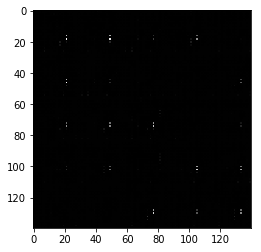

Epoch 1/10... Batch 710... Discriminator Loss: 0.0002... Generator Loss: 27.3782
Epoch 1/10... Batch 720... Discriminator Loss: 0.0000... Generator Loss: 31.7343
Epoch 1/10... Batch 730... Discriminator Loss: 0.0000... Generator Loss: 29.5834
Epoch 1/10... Batch 740... Discriminator Loss: 0.0012... Generator Loss: 22.6182
Epoch 1/10... Batch 750... Discriminator Loss: 0.0000... Generator Loss: 30.2094
Epoch 1/10... Batch 760... Discriminator Loss: 0.0001... Generator Loss: 27.3501
Epoch 1/10... Batch 770... Discriminator Loss: 0.0005... Generator Loss: 23.8102
Epoch 1/10... Batch 780... Discriminator Loss: 0.0014... Generator Loss: 19.4935
Epoch 1/10... Batch 790... Discriminator Loss: 0.0239... Generator Loss: 17.7539
Epoch 1/10... Batch 800... Discriminator Loss: 0.0041... Generator Loss: 21.2687


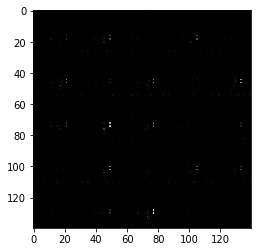

Epoch 1/10... Batch 810... Discriminator Loss: 0.0010... Generator Loss: 19.3248
Epoch 1/10... Batch 820... Discriminator Loss: 0.0015... Generator Loss: 20.4424
Epoch 1/10... Batch 830... Discriminator Loss: 0.0005... Generator Loss: 20.9185
Epoch 1/10... Batch 840... Discriminator Loss: 0.0022... Generator Loss: 20.7714
Epoch 1/10... Batch 850... Discriminator Loss: 0.0362... Generator Loss: 13.7161
Epoch 1/10... Batch 860... Discriminator Loss: 0.0007... Generator Loss: 19.9995
Epoch 1/10... Batch 870... Discriminator Loss: 0.0007... Generator Loss: 21.0345
Epoch 1/10... Batch 880... Discriminator Loss: 0.0001... Generator Loss: 23.6560
Epoch 1/10... Batch 890... Discriminator Loss: 0.0052... Generator Loss: 18.4880
Epoch 1/10... Batch 900... Discriminator Loss: 0.0135... Generator Loss: 20.8425


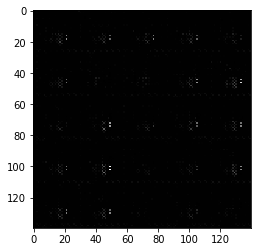

Epoch 1/10... Batch 910... Discriminator Loss: 0.0000... Generator Loss: 43.3624
Epoch 1/10... Batch 920... Discriminator Loss: 0.0000... Generator Loss: 38.8140
Epoch 1/10... Batch 930... Discriminator Loss: 0.0000... Generator Loss: 36.7551
Epoch 1/10... Batch 940... Discriminator Loss: 0.0000... Generator Loss: 40.7791
Epoch 1/10... Batch 950... Discriminator Loss: 0.0000... Generator Loss: 41.0201
Epoch 1/10... Batch 960... Discriminator Loss: 0.0000... Generator Loss: 38.1871
Epoch 1/10... Batch 970... Discriminator Loss: 0.0000... Generator Loss: 32.8350
Epoch 1/10... Batch 980... Discriminator Loss: 0.0000... Generator Loss: 33.3683
Epoch 1/10... Batch 990... Discriminator Loss: 0.0000... Generator Loss: 30.3227
Epoch 1/10... Batch 1000... Discriminator Loss: 0.0002... Generator Loss: 26.6742


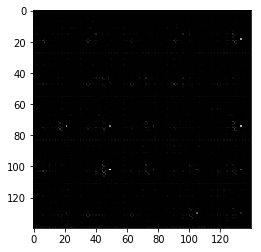

Epoch 1/10... Batch 1010... Discriminator Loss: 0.0109... Generator Loss: 20.2865
Epoch 1/10... Batch 1020... Discriminator Loss: 25.9925... Generator Loss: 4.8625
Epoch 1/10... Batch 1030... Discriminator Loss: 0.0000... Generator Loss: 80.0399
Epoch 1/10... Batch 1040... Discriminator Loss: 0.0000... Generator Loss: 74.8938
Epoch 1/10... Batch 1050... Discriminator Loss: 0.0000... Generator Loss: 60.5409
Epoch 1/10... Batch 1060... Discriminator Loss: 0.0000... Generator Loss: 86.0645
Epoch 1/10... Batch 1070... Discriminator Loss: 0.0000... Generator Loss: 68.6398
Epoch 1/10... Batch 1080... Discriminator Loss: 0.0000... Generator Loss: 63.5551
Epoch 1/10... Batch 1090... Discriminator Loss: 0.0000... Generator Loss: 69.7030
Epoch 1/10... Batch 1100... Discriminator Loss: 0.0000... Generator Loss: 46.4316


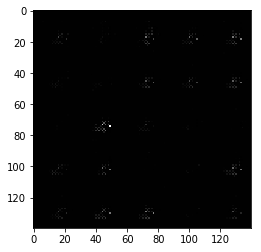

Epoch 1/10... Batch 1110... Discriminator Loss: 21.1110... Generator Loss: 13.6251
Epoch 1/10... Batch 1120... Discriminator Loss: 0.0000... Generator Loss: 180.2866
Epoch 1/10... Batch 1130... Discriminator Loss: 0.0000... Generator Loss: 120.7267
Epoch 1/10... Batch 1140... Discriminator Loss: 0.0000... Generator Loss: 60.3128
Epoch 1/10... Batch 1150... Discriminator Loss: 0.0000... Generator Loss: 250.7035
Epoch 1/10... Batch 1160... Discriminator Loss: 0.0000... Generator Loss: 231.3850
Epoch 1/10... Batch 1170... Discriminator Loss: 0.0000... Generator Loss: 214.9773
Epoch 1/10... Batch 1180... Discriminator Loss: 0.0000... Generator Loss: 172.9824
Epoch 1/10... Batch 1190... Discriminator Loss: 0.0000... Generator Loss: 205.3979
Epoch 1/10... Batch 1200... Discriminator Loss: 0.0000... Generator Loss: 164.2402


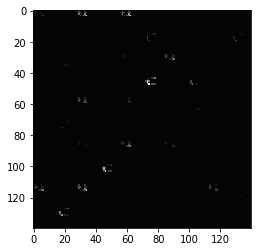

Epoch 1/10... Batch 1210... Discriminator Loss: 0.0000... Generator Loss: 191.6348
Epoch 1/10... Batch 1220... Discriminator Loss: 0.0000... Generator Loss: 136.2109
Epoch 1/10... Batch 1230... Discriminator Loss: 0.0000... Generator Loss: 158.1060
Epoch 1/10... Batch 1240... Discriminator Loss: 0.0000... Generator Loss: 151.1246
Epoch 1/10... Batch 1250... Discriminator Loss: 0.0000... Generator Loss: 125.8325
Epoch 1/10... Batch 1260... Discriminator Loss: 0.0000... Generator Loss: 123.0523
Epoch 1/10... Batch 1270... Discriminator Loss: 0.0000... Generator Loss: 70.8877
Epoch 1/10... Batch 1280... Discriminator Loss: 0.0000... Generator Loss: 249.5998
Epoch 1/10... Batch 1290... Discriminator Loss: 0.0000... Generator Loss: 208.1674
Epoch 1/10... Batch 1300... Discriminator Loss: 0.0000... Generator Loss: 213.5584


In [ ]:
batch_size = 5
z_dim = 10
learning_rate = 0.01
beta1 = 0.01

epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.